# Improved Breast Cancer Classification Notebook
This notebook loads your breast cancer dataset, preprocesses it, builds an improved neural network with BatchNorm, Dropout, and early stopping, and evaluates performance with AUC and optimal thresholding.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Activation
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Load data
data = pd.read_csv('Breast_cancer_data.csv')
data.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0


In [ ]:
# Preprocess
X = data.drop('diagnosis', axis=1).values
y = data['diagnosis'].values
# Stratified split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, stratify=y_trainval, test_size=0.25, random_state=42
)
# Scale features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [ ]:
# Compute class weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced', classes=np.unique(y_train), y=y_train
)
class_weights = dict(enumerate(class_weights))

In [ ]:
# Build model
def build_model(input_dim):
    model = Sequential([
        Dense(64, input_shape=(input_dim,)),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),
        Dense(32),
        BatchNormalization(),
        Activation('relu'),
        Dropout(0.3),
        Dense(16),
        Activation('relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=['accuracy']
    )
    return model

model = build_model(X_train.shape[1])
model.summary()

C:\Users\sebas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,393 (13.25 KB)

 Trainable params: 3,201 (12.50 KB)

 Non-trainable params: 192 (768.00 B)

In [ ]:
# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)
]

In [ ]:
# Train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5098 - loss: 0.7708 - val_accuracy: 0.8509 - val_loss: 0.6416 - learning_rate: 0.0010
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6760 - loss: 0.6281 - val_accuracy: 0.8158 - val_loss: 0.6163 - learning_rate: 0.0010
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7304 - loss: 0.5667 - val_accuracy: 0.8684 - val_loss: 0.5882 - learning_rate: 0.0010
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7990 - loss: 0.5016 - val_accuracy: 0.9386 - val_loss: 0.5545 - learning_rate: 0.0010
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8484 - loss: 0.4449 - val_accuracy: 0.9298 - val_loss: 0.5204 - learning_rate: 0.0010
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8512 - loss: 0.4283 - val_accuracy: 0.9386 - val_loss: 0.4822 - learning_rate: 0.0010
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8813 - loss: 0.3540 - va

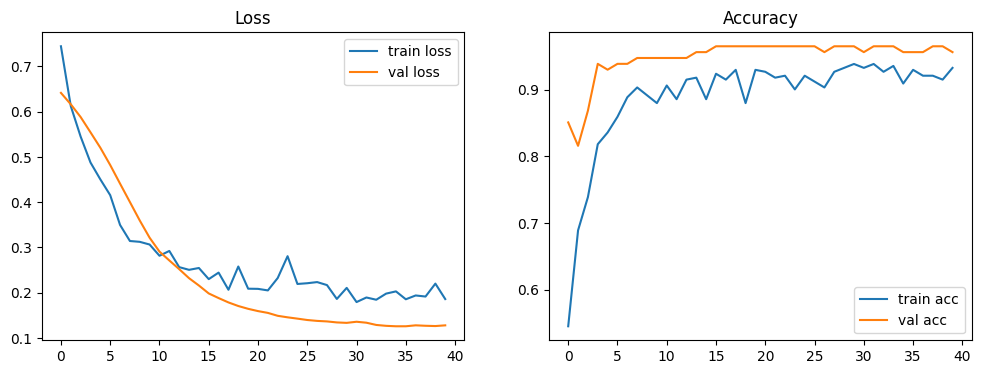

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Test AUC: 0.9706


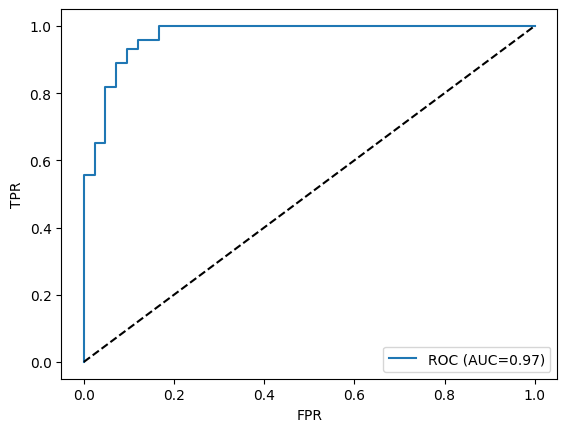

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Optimal threshold: 0.426
Accuracy @ optimal threshold: 0.8772
[[39  3]
 [11 61]]
              precision    recall  f1-score   support

           0       0.78      0.93      0.85        42
           1       0.95      0.85      0.90        72

    accuracy                           0.88       114
   macro avg       0.87      0.89      0.87       114
weighted avg       0.89      0.88      0.88       114



In [ ]:
# Evaluate
import matplotlib.pyplot as plt
# Plot training history
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title('Accuracy')
plt.show()

# ROC & AUC on test set
y_prob = model.predict(X_test).ravel()
auc = roc_auc_score(y_test, y_prob)
print(f"Test AUC: {auc:.4f}")
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f'ROC (AUC={auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()
plt.show()

# Optimal threshold via Youden's J on validation set
y_val_prob = model.predict(X_val).ravel()
fpr_val, tpr_val, thresh_val = roc_curve(y_val, y_val_prob)
j_scores = tpr_val - fpr_val
best_thresh = thresh_val[np.argmax(j_scores)]
print(f"Optimal threshold: {best_thresh:.3f}")

# Evaluate at optimal threshold
y_pred_opt = (y_prob >= best_thresh).astype(int)
acc_opt = accuracy_score(y_test, y_pred_opt)
print(f"Accuracy @ optimal threshold: {acc_opt:.4f}")
print(confusion_matrix(y_test, y_pred_opt))
print(classification_report(y_test, y_pred_opt))

Accuracy = (TP + TN) / (TP + FP + TN + FN)
How many total predictions I got right. 
Misleading when classes are imbalanced.
ie. (if 90% of cases are benign, predicting “benign” always gives you 90% accuracy, even if you miss all cancers.)

Precision = TP / (TP + FP)
Positive predicted value
High precision = few FP
Important when false positives have consequences (stressing the patient out)
ie. (When I predict cancer, how often am I right)

Recall/Sensitivity/True Positive Rate(TPR) = TP / (TP + FN)
High recall = few missed cancers
Important if you don't want to miss true positives
ie.(Of all actual cancer cases, how many did I catch)

Specificity/True Negative Rate(TNR) = TN / (TN + FP)
High specificity = few false alarms
Important to avoid false alarms.
ie. (Of all healthy people, how many did I correctly predict are healthy)

False Positive Rate(FPR) = 1 - specificity = FP / (FP + TN)
ie. (How often do I incorrectly say someone has cancer when they don't)

False Negative Rate(FNR) = 1 - recall = FN / (FN + TP)
ie. (How often do i miss cancer when it's really there)

F1 score = 2 * ( (Precision * Recall) / (Precision + Recall) )
Balance between false alarms and missed cases
Useful for imbalanced data. 

AUC-ROC (Area Under ROC Curve) 
Measures ability to rank positives above negatives regardless of threshold
.5 = random to 1 = perfect
Useful for comparing classifiers before picking decision threshold

AUC-PR (Precision-Recall Curve)
Better than ROC when positives are rare (ie. only 10% positives)
Focuses on how well model performs on positive class

Confusion Matrix
0 TN 	FP 
1 FN 	TP 

Best for cancer prediction
1. Recall/sensitivity - Catch as many positives as possible. High = good
2. Precision/specificity - Minimize false alarms. High = good
3. 